In [217]:
import pandas as pd
import numpy as np
import requests

In [236]:
def get_data(token):
    if token in ['ETH', 'SOL', 'AVAX','USDT']:
        res = requests.get(
            f'https://api.cryptowat.ch/markets/coinbase-pro/{token}usd/ohlc',
            params={
                'periods': '3600',
                'after': str(int(pd.Timestamp('2021-11-22').timestamp()))
            }
        )
    else:
        res = requests.get(
            f'https://api.cryptowat.ch/markets/kraken/{token}usd/ohlc',
            params={
                'periods': '3600',
                'after': str(int(pd.Timestamp('2021-11-22').timestamp()))
            }
        )

    df = pd.DataFrame(
        res.json()['result']['3600'],
        columns=['ts', 'open', 'high', 'low', 'close', 'volume', 'volumeUSD']
    )
    df['ts'] = pd.to_datetime(df.ts, unit='s')
    df['token'] = token
    
    return df

In [237]:
tokens = ['ETH', 'SOL', 'AVAX', 'USDT', 'FLOW']

In [238]:
df=[get_data(token) for token in tokens]

In [239]:
df_base = pd.concat(df, keys=tokens) 

In [240]:
df_volumneUSD = df_base.groupby('token')['volumeUSD'].sum().to_frame()

In [241]:
df_volumneUSD.sort_values('volumeUSD', ascending=False)

,volumeUSD
token,
ETH,2.168852e+10
SOL,7.105881e+09
AVAX,3.550485e+09
USDT,2.023695e+09
FLOW,8.895380e+07


In [242]:
df_ETH_SOL = pd.merge(
             df[0][['ts', 'close']].rename(columns={'close': f'close_{tokens[0]}'}),
             df[1][['ts', 'close']].rename(columns={'close': f'close_{tokens[1]}'}),
             on='ts',
             how='inner'
             )

In [243]:
df_ETH_SOL['close_price_ratio']=df_ETH_SOL['close_ETH']/df_ETH_SOL['close_SOL']

In [244]:
df_ETH_SOL

,ts,close_ETH,close_SOL,close_price_ratio
0,2021-11-22 00:00:00,4262.99,230.785,18.471694
1,2021-11-22 01:00:00,4234.37,226.000,18.736150
2,2021-11-22 02:00:00,4217.89,227.037,18.577985
3,2021-11-22 03:00:00,4193.47,223.117,18.794937
4,2021-11-22 04:00:00,4168.35,220.652,18.891059
...,...,...,...,...
554,2021-12-15 02:00:00,3837.20,160.850,23.855766
555,2021-12-15 03:00:00,3828.12,160.570,23.840817
556,2021-12-15 04:00:00,3848.94,160.600,23.966002
557,2021-12-15 05:00:00,3857.92,161.700,23.858503


In [245]:
df_base.rename(columns={'volume':'volumeBase', 'volumeUSD':'volumeTerm'})

ts      open      high       low     close  \
ETH  0   2021-11-22 00:00:00  4317.980  4342.240  4246.070  4262.990   
     1   2021-11-22 01:00:00  4263.040  4270.340  4212.450  4234.370   
     2   2021-11-22 02:00:00  4234.870  4246.720  4171.170  4217.890   
     3   2021-11-22 03:00:00  4217.880  4223.480  4163.580  4193.470   
     4   2021-11-22 04:00:00  4192.950  4213.590  4147.000  4168.350   
...                      ...       ...       ...       ...       ...   
FLOW 554 2021-12-15 02:00:00     8.615     8.653     8.515     8.553   
     555 2021-12-15 03:00:00     8.534     8.534     8.521     8.521   
     556 2021-12-15 04:00:00     8.540     8.623     8.537     8.623   
     557 2021-12-15 05:00:00     8.601     8.635     8.538     8.550   
     558 2021-12-15 06:00:00     8.547     8.556     8.538     8.538   

             volumeBase    volumeTerm token  
ETH  0      7262.562789  3.123077e+07   ETH  
     1      8437.946084  3.574586e+07   ETH  
     2      9259.725370  3.895639e+07   ETH  
     3      9259.899519  3.882032e+07   ETH  
     4      7934.546906  3.315476e+07   ETH  
...                 ...           ...   ...  
FLOW 554  106802.757771  9.150774e+05  FLOW  
     555   10747.603238  9.159770e+04  FLOW  
     556    2283.862711  1.953827e+04  FLOW  
     557   18545.642253  1.588681e+05  FLOW  
     558      13.352858  1.141357e+02  FLOW  

[2795 rows x 8 columns]

In [246]:
def clean_dataframe(original_df):
    cleaned_df = original_df.set_index('ts')['close'].rename(f'close_{original_df.token[0]}').to_frame()
    return cleaned_df 

In [247]:
cleaned_dataframes = [clean_dataframe(original_df) for original_df in df]

In [248]:
cleaned_dataframes[0]

,close_ETH
ts,
2021-11-22 00:00:00,4262.99
2021-11-22 01:00:00,4234.37
2021-11-22 02:00:00,4217.89
2021-11-22 03:00:00,4193.47
2021-11-22 04:00:00,4168.35
...,...
2021-12-15 02:00:00,3837.20
2021-12-15 03:00:00,3828.12
2021-12-15 04:00:00,3848.94


In [249]:
import functools 

In [250]:
joined_pdf = functools.reduce(lambda a, b: a.join(b), cleaned_dataframes)

In [251]:
joined_pdf

,close_ETH,close_SOL,close_AVAX,close_USDT,close_FLOW
ts,,,,,
2021-11-22 00:00:00,4262.99,230.785,128.67,1.0012,14.150
2021-11-22 01:00:00,4234.37,226.000,134.85,1.0013,13.621
2021-11-22 02:00:00,4217.89,227.037,132.54,1.0012,13.753
2021-11-22 03:00:00,4193.47,223.117,133.38,1.0011,13.652
2021-11-22 04:00:00,4168.35,220.652,136.29,1.0009,13.581
...,...,...,...,...,...
2021-12-15 02:00:00,3837.20,160.850,88.60,1.0005,8.553
2021-12-15 03:00:00,3828.12,160.570,88.69,1.0004,8.521
2021-12-15 04:00:00,3848.94,160.600,90.37,1.0004,8.623


In [252]:
df_log_return = [(lambda x: x.assign(log_return=np.log(x.close)-np.log(x.close.shift(1))))(df_original) for df_original in df]

In [253]:
df_log_return[0]

,ts,open,high,low,close,volume,volumeUSD,token,log_return
0,2021-11-22 00:00:00,4317.98,4342.24,4246.07,4262.99,7262.562789,3.123077e+07,ETH,NaN
1,2021-11-22 01:00:00,4263.04,4270.34,4212.45,4234.37,8437.946084,3.574586e+07,ETH,-0.006736
2,2021-11-22 02:00:00,4234.87,4246.72,4171.17,4217.89,9259.725370,3.895639e+07,ETH,-0.003900
3,2021-11-22 03:00:00,4217.88,4223.48,4163.58,4193.47,9259.899519,3.882032e+07,ETH,-0.005806
4,2021-11-22 04:00:00,4192.95,4213.59,4147.00,4168.35,7934.546906,3.315476e+07,ETH,-0.006008
...,...,...,...,...,...,...,...,...,...
554,2021-12-15 02:00:00,3850.12,3850.43,3820.59,3837.20,7985.087317,3.061840e+07,ETH,-0.003595
555,2021-12-15 03:00:00,3837.30,3840.52,3804.20,3828.12,6778.556107,2.589926e+07,ETH,-0.002369
556,2021-12-15 04:00:00,3828.47,3850.00,3819.07,3848.94,4150.361951,1.589684e+07,ETH,0.005424
557,2021-12-15 05:00:00,3848.94,3895.58,3826.13,3857.92,8607.636619,3.325520e+07,ETH,0.002330


In [254]:
def clean_dataframe_2(original_df):
    cleaned_df = original_df.set_index('ts')['log_return'].rename(f'log_return_{original_df.token[0]}').to_frame()
    return cleaned_df 

In [255]:
clean_data_lr = [clean_dataframe_2(original_df) for original_df in df_log_return]

In [256]:
clean_data_lr[0]

,log_return_ETH
ts,
2021-11-22 00:00:00,NaN
2021-11-22 01:00:00,-0.006736
2021-11-22 02:00:00,-0.003900
2021-11-22 03:00:00,-0.005806
2021-11-22 04:00:00,-0.006008
...,...
2021-12-15 02:00:00,-0.003595
2021-12-15 03:00:00,-0.002369
2021-12-15 04:00:00,0.005424


In [257]:
joined_pd_lr = functools.reduce(lambda a, b: a.join(b), clean_data_lr)

In [258]:
joined_pd_lr

,log_return_ETH,log_return_SOL,log_return_AVAX,log_return_USDT,log_return_FLOW
ts,,,,,
2021-11-22 00:00:00,NaN,NaN,NaN,NaN,NaN
2021-11-22 01:00:00,-0.006736,-0.020952,0.046912,0.0001,-0.038102
2021-11-22 02:00:00,-0.003900,0.004578,-0.017279,-0.0001,0.009644
2021-11-22 03:00:00,-0.005806,-0.017417,0.006318,-0.0001,-0.007371
2021-11-22 04:00:00,-0.006008,-0.011109,0.021583,-0.0002,-0.005214
...,...,...,...,...,...
2021-12-15 02:00:00,-0.003595,-0.002174,-0.005066,0.0001,-0.010236
2021-12-15 03:00:00,-0.002369,-0.001742,0.001015,-0.0001,-0.003748
2021-12-15 04:00:00,0.005424,0.000187,0.018765,0.0000,0.011899


In [259]:
joined_pd_lr.corr()

,log_return_ETH,log_return_SOL,log_return_AVAX,log_return_USDT,log_return_FLOW
log_return_ETH,1.000000,0.743368,0.643031,-0.119078,0.565307
log_return_SOL,0.743368,1.000000,0.622076,0.100495,0.450465
log_return_AVAX,0.643031,0.622076,1.000000,-0.017796,0.391637
log_return_USDT,-0.119078,0.100495,-0.017796,1.000000,-0.192641
log_return_FLOW,0.565307,0.450465,0.391637,-0.192641,1.000000


In [260]:
import matplotlib.pyplot as plt

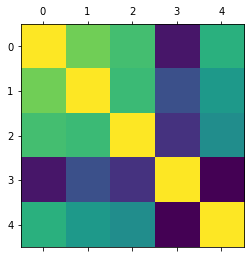

In [261]:
plt.matshow(joined_pd_lr.corr())
plt.show()